# Resting State - Classical Features - GMM Clustering

## 0. Imports & Constants

### Libraries

In [1]:
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, adjusted_rand_score, make_scorer

from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, cross_val_score

import umap.umap_ as umap
from scipy.stats import f_oneway

In [2]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from FeatureExtraction import FeatureExtractor, FEUtilz
from Evaluation import Evaluation

### Constans

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
FEATURES_DATA_PATH = rf"..\results\Resting State - best\resting_state_feature_table_22_05_2025_16_25.csv"
CLINICAL_DATA_PATH = rf'C:\Users\97254\Projects Data\ClusteringPD\cluestring_pd_clinical_data.xlsx'

CLINICAL_FEATURE_NAMES = ['Age', 'Disease duration', 
                        'LEDD', 'MoCA', 'UPDRS Total', 'UPDRS part III', 
                        'Gait speed usual', 'Gait speed DT', 
                        'CTT1', 'CTT2']

VGNG_FEATURE_NAMES = ['Vgng_sit_GO_CorrectPercent', 'Vgng_sit_NOGO_CorrectPercent', 'Vgng_walk_GO_CorrectPercent', 
                    'Vgng_walk_NOGO_CorrectPercent', 'Vgng_sit_GO_RT_Mean', 'Vgng_walk_GO_RT_Mean']

MODEL_FEATURE_NAMES = [
    'LZC_mean', 'PermEn_mean', 'fooof_exponent', 
    'beta_relative_bandpower', 'gamma_relative_bandpower', 'alpha_relative_bandpower', 'theta_relative_bandpower'
]

N_INIT = 3
N_SEARCHES = 100
RANDOM_STATE = 42

### Import Data

In [5]:
feature_table = pd.read_csv(FEATURES_DATA_PATH)
feature_table = feature_table.loc[feature_table['FeatureName'].isin(MODEL_FEATURE_NAMES)]
feature_table['Task'] = feature_table['Condition'].str.split('_').str[0]
feature_table['Condition'] = feature_table['Condition'].str.split('_').str[1]

In [6]:
feature_table['FeatureName'].unique()

array(['LZC_mean', 'PermEn_mean', 'fooof_exponent',
       'theta_relative_bandpower', 'alpha_relative_bandpower',
       'beta_relative_bandpower', 'gamma_relative_bandpower'],
      dtype=object)

In [7]:
data, subjects, raw_feature_names = FEUtilz.get_feature_matrix(feature_table, normalize=True, agg_regions=True)

In [8]:
PD_mask = pd.Series(subjects).str.startswith('PD')

PD_data = data[PD_mask, :]
HC_data = data[~PD_mask, :]

PD_subjects = subjects[PD_mask]

In [9]:
PD_data.shape

(116, 182)

### A Vanilla Model

In the following cells, the basic "vanilla" model is defined and initialized.

All the other arguments are assigned wth their default values (given by `sklearn`).

In [10]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [11]:
vanilla_gmm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('GMM', GaussianMixture(n_components=3, n_init=N_INIT))
])

In [12]:
evaluator = Evaluation(models=[vanilla_gmm], names=['Vanilla Model'], cl_data_path=CLINICAL_DATA_PATH, cl_fnames=CLINICAL_FEATURE_NAMES
                       , PD_data=PD_data, PD_subjects=PD_subjects, HC_data=HC_data, cl_VGNG_names=VGNG_FEATURE_NAMES)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Vanilla Model          
Statistic                 Mean       STD
Metric                                  
CH_score             31.129538  0.534356
DBI_score             1.786043  0.024770
Validity              1.000000  0.000000
silhouette_score      0.156363  0.002094 

-------------------------------------- Low Dimensional Visualization -------------------------------------



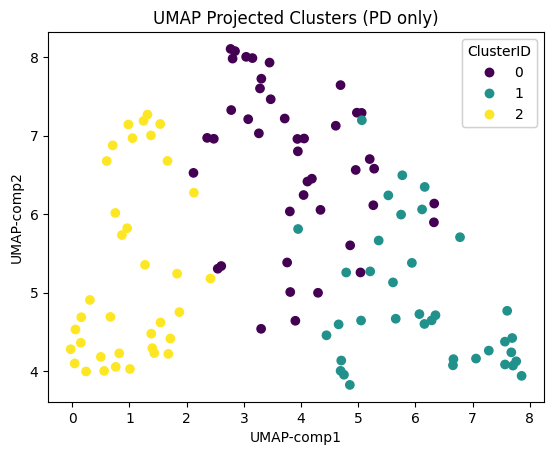

-------------------------------------- Clinical Metrics Differences -------------------------------------



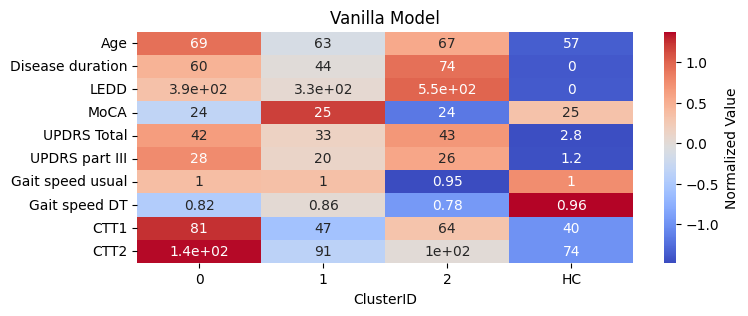

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



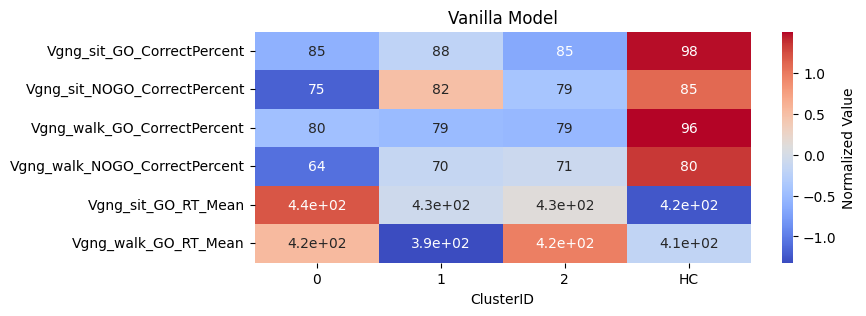

In [13]:
evaluator.report()

## 1. Hyperparameter Tuning

In [47]:
cv = LeaveOneOut()

In [48]:
def neg_bic(estimator, X, y=None):
    Xp = estimator[:-1].transform(X)
    return -estimator[-1].bic(Xp)

In [49]:
gmm_params = {
    'GMM__covariance_type': ['full', 'diag', 'spherical', 'tied'],
    'GMM__reg_covar': np.logspace(-8, -4, 20),
    'GMM__init_params': ['kmeans', 'k-means++']
}

### Vanilla-GMM

#### K = 2

In [33]:
vanilla_gmm_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('GMM', GaussianMixture(n_components=2, n_init=N_INIT))
])

vanilla_grid_2 = RandomizedSearchCV(
    vanilla_gmm_2,
    gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [34]:
vanilla_grid_2.fit(PD_data)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                                             'k-means++'],
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04])},
                   verbose=1)

In [35]:
vanilla_gmm_2 = vanilla_grid_2.best_estimator_

#### K = 3

In [36]:
vanilla_gmm_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('GMM', GaussianMixture(n_components=3, n_init=N_INIT))
])

vanilla_grid_3 = RandomizedSearchCV(
    vanilla_gmm_3,
    gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [37]:
vanilla_grid_3.fit(PD_data)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                                             'k-means++'],
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04])},
                   verbose=1)

In [38]:
vanilla_gmm_3 = vanilla_grid_3.best_estimator_

### PCA-GMM

#### K = 2

In [39]:
PCA_gmm_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('GMM', GaussianMixture(n_components=2, n_init=N_INIT))
])

PCA_gmm_params = {
    'PCA__n_components': [0.7, 0.8, 0.9, 0.95]
}

PCA_gmm_params.update(gmm_params)

PCA_gmm_grid_2 = RandomizedSearchCV(
    PCA_gmm_2,
    PCA_gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [40]:
PCA_gmm_grid_2.fit(PD_data)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04]),
                                        'PCA__n_components': [0.7, 0.8, 0.9,
                                                              0.95]},
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Best PCA Model              Vanilla          
Statistic                  Mean       STD       Mean       STD
Metric                                                        
CH_score              51.184410  6.709947  28.968711  7.895458
DBI_score              1.333814  0.111426   1.908199  0.368491
Validity               1.000000  0.000000   1.000000  0.000000
silhouette_score       0.267135  0.013550   0.173487  0.035029 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

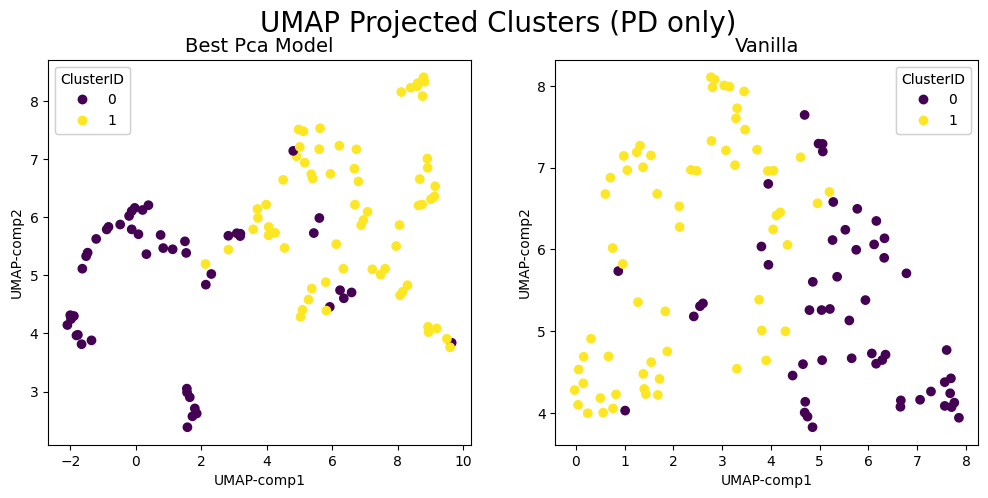

In [41]:
PCA_gmm_2 = PCA_gmm_grid_2.best_estimator_
evaluator.set_models(models=[PCA_gmm_2, vanilla_gmm_2], names=['Best PCA Model', 'Vanilla'])
evaluator.report(include_clinical=False)

#### K = 3

In [42]:
PCA_gmm_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('GMM', GaussianMixture(n_components=3, n_init=N_INIT))
])

PCA_gmm_grid_3 = RandomizedSearchCV(
    PCA_gmm_3,
    PCA_gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [43]:
PCA_gmm_grid_3.fit(PD_data)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 1...
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04]),
                                        'PCA__n_components': [0.7, 0.8, 0.9,
                                                              0.95]},
                   verbose=1)

In [44]:
PCA_gmm_3 = PCA_gmm_grid_3.best_estimator_
evaluator.set_models(models=[PCA_gmm_3, vanilla_gmm_3], names=['Best PCA Model', 'Vanilla'])
evaluator.report(include_clinical=False)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------



KeyboardInterrupt: 

### UMAP-GMM

#### K = 2

In [50]:
UMAP_gmm_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP()),
    ('GMM', GaussianMixture(n_components=2, n_init=N_INIT))
])

UMAP_gmm_params = {
    'UMAP__n_components': np.arange(3, 22, 3),
    'UMAP__n_neighbors': np.arange(5, 21, 5)
}

UMAP_gmm_params.update(gmm_params)

UMAP_gmm_grid_2 = RandomizedSearchCV(
    UMAP_gmm_2,
    UMAP_gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [51]:
UMAP_gmm_grid_2.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2537 fits failed out of a total of 11600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2034 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\97254\AppData\

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP()),
                                             ('GMM',
                                              GaussianMixture(n_components=2,
                                                              n_init=3))]),
                   n_iter=100,
                   param_distributions={'GMM__covariance_type': ['full', 'diag',
                                                                 'spherical',
                                                                 'tied'],
                                        'GMM__init_params': ['kmeans',
                                                             'k-means++'],
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04]),
                                        'UMAP__n_components': array([ 3,  6,  9, 12, 15, 18, 21]),
                                        'UMAP__n_neighbors': array([ 5, 10, 15, 20])},
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Best UMAP Model               Vanilla          
Statistic                   Mean        STD       Mean       STD
Metric                                                          
CH_score               66.632006  34.375329  29.545328  7.983700
DBI_score               1.200299   0.456509   1.873210  0.335965
Validity                1.000000   0.000000   1.000000  0.000000
silhouette_score        0.324248   0.093509   0.177005  0.036149 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

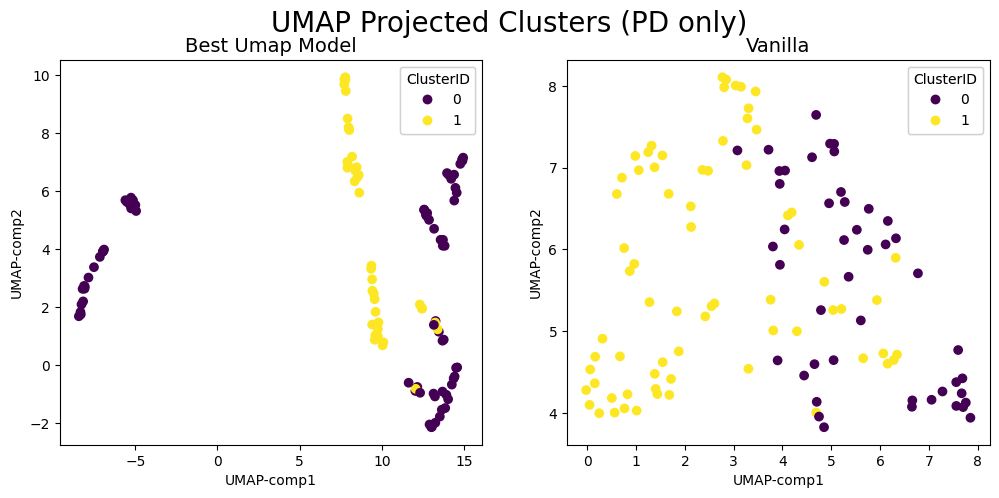

In [52]:
UMAP_gmm_2 = UMAP_gmm_grid_2.best_estimator_
evaluator.set_models(models=[UMAP_gmm_2, vanilla_gmm_2], names=['Best UMAP Model', 'Vanilla'])
evaluator.report(include_clinical=False)

#### K = 3

In [53]:
UMAP_gmm_3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP()),
    ('GMM', GaussianMixture(n_components=3, n_init=N_INIT))
])

UMAP_gmm_grid_3 = RandomizedSearchCV(
    UMAP_gmm_3,
    UMAP_gmm_params,
    n_iter=N_SEARCHES,
    cv=cv,
    verbose=1
)

In [54]:
UMAP_gmm_grid_3.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1494 fits failed out of a total of 11600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\mixture\_gaussian_mixture.py", line 337, in _compute_precision_cholesky
    cov_chol = linalg.cholesky(covariances, lower=True)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_decomp_cholesky.py", line 90, in cholesky
    c, lower = _cholesky(a, lower=l

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP()),
                                             ('GMM',
                                              GaussianMixture(n_components=3,
                                                              n_init=3))]),
                   n_iter=100,
                   param_distributions={'GMM__covariance_type': ['full', 'diag',
                                                                 'spherical',
                                                                 'tied'],
                                        'GMM__init_params': ['kmeans',
                                                             'k-means++'],
                                        'GMM__reg_covar': array([1.00000000e-08, 1.62377674e-08, 2.63665090e-08, 4.28133240e-08,
       6.95192796e-08, 1.12883789e-07, 1.83298071e-07, 2.97635144e-07,
       4.83293024e-07, 7.84759970e-07, 1.27427499e-06, 2.06913808e-06,
       3.35981829e-06, 5.45559478e-06, 8.85866790e-06, 1.43844989e-05,
       2.33572147e-05, 3.79269019e-05, 6.15848211e-05, 1.00000000e-04]),
                                        'UMAP__n_components': array([ 3,  6,  9, 12, 15, 18, 21]),
                                        'UMAP__n_neighbors': array([ 5, 10, 15, 20])},
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Best UMAP Model               Vanilla          
Statistic                   Mean        STD       Mean       STD
Metric                                                          
CH_score              132.871199  24.164302  31.169871  0.444924
DBI_score               0.818390   0.080308   1.787010  0.016040
Validity                1.000000   0.000000   1.000000  0.000000
silhouette_score        0.419167   0.037974   0.156725  0.002398 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

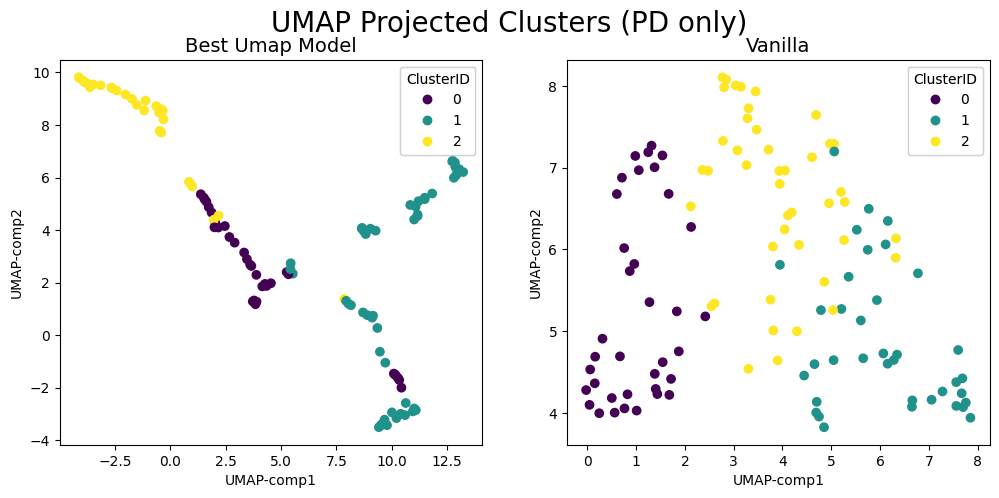

In [55]:
UMAP_gmm_3 = UMAP_gmm_grid_3.best_estimator_
evaluator.set_models(models=[UMAP_gmm_3, vanilla_gmm_3], names=['Best UMAP Model', 'Vanilla'])
evaluator.report(include_clinical=False)

### Stability

In [56]:
def calc_stability(estimator, data: np.ndarray, name: str, validation_trials: int = 100):
    clusters = [estimator.fit_predict(data) for _ in range(validation_trials)]

    ARIs = [
        adjusted_rand_score(clusters[i], clusters[j])
        for i in range(validation_trials)
        for j in range(i+1, validation_trials)
    ]

    mean_ARI = np.mean(ARIs)
    std_ARI = np.std(ARIs)
    print(f"Adjusted Rand Index for {name} is {round(mean_ARI, 2)} ({round(std_ARI, 2)}) [mean (std)].")

#### Vanilla

In [57]:
calc_stability(vanilla_gmm_2, PD_data, name='Vanilla-GMM [K=2]')

Adjusted Rand Index for Vanilla-GMM [K=2] is 0.31 (0.22) [mean (std)].


In [58]:
calc_stability(vanilla_gmm_3, PD_data, name='Vanilla-GMM [K=3]')

KeyboardInterrupt: 

#### PCA

In [ ]:
calc_stability(PCA_gmm_2, PD_data, name='PCA-GMM [K=2]')

Adjusted Rand Index for PCA-GMM [K=2] is 0.71 (0.26) [mean (std)].


In [ ]:
calc_stability(PCA_gmm_3, PD_data, name='PCA-GMM [K=3]')

Adjusted Rand Index for PCA-GMM [K=3] is 0.4 (0.2) [mean (std)].


#### UMAP

In [59]:
UMAP_gmm_2['UMAP'].random_state = None
calc_stability(UMAP_gmm_2, PD_data, name='UMAP-GMM [K=2]')

Adjusted Rand Index for UMAP-GMM [K=2] is 0.2 (0.26) [mean (std)].


In [123]:
UMAP_gmm_3['UMAP'].random_state = None
calc_stability(UMAP_gmm_3, PD_data, name='UMAP-GMM [K=3]')

Adjusted Rand Index for UMAP-GMM [K=3] is 0.58 (0.16) [mean (std)].


## 2. Final Model Training & Evaluation 

#### Selecting K

In [61]:
bic_2 = cross_val_score(UMAP_gmm_grid_2.best_estimator_, PD_data, cv=cv, scoring=neg_bic)
bic_2.mean(), bic_2.std()

(np.float64(-10.008382735790232), np.float64(2.699623035299221))

In [62]:
bic_3 = cross_val_score(UMAP_gmm_grid_3.best_estimator_, PD_data, cv=cv, scoring=neg_bic)
bic_3.mean(), bic_3.std()

(np.float64(-10.160305539292814), np.float64(3.320289414460874))

#### General Evaluation

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        UMAP-GMM [K=3]           
Statistic                  Mean        STD
Metric                                    
CH_score             133.571168  26.356931
DBI_score              0.802619   0.076622
Validity               1.000000   0.000000
silhouette_score       0.426097   0.036458 

-------------------------------------- Low Dimensional Visualization -------------------------------------



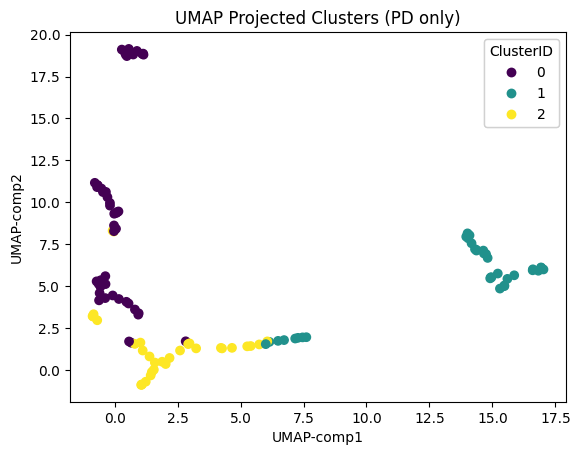

-------------------------------------- Clinical Metrics Differences -------------------------------------



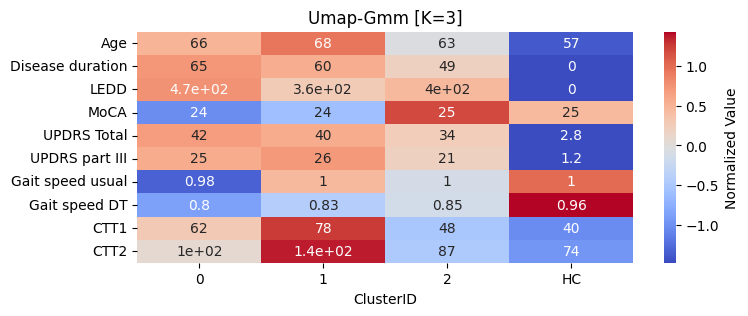

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



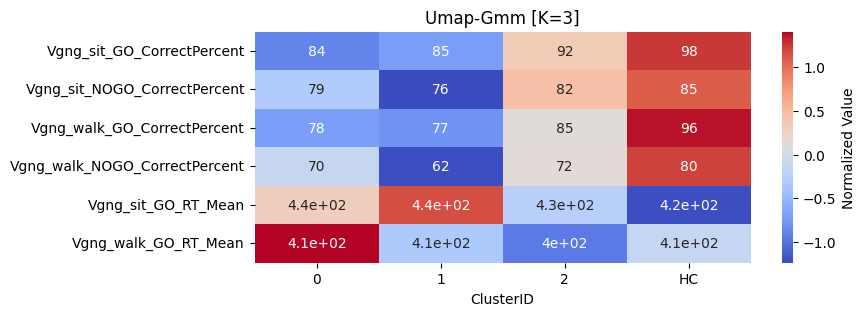

In [93]:
best_model = UMAP_gmm_grid_3.best_estimator_
best_model.named_steps['UMAP'].random_state = RANDOM_STATE
best_model.named_steps['GMM'].random_state = RANDOM_STATE

joblib.dump(best_model, "UMAP_GMM.pkl")

evaluator.set_models(models=[best_model], names=['UMAP-GMM [K=3]'])
evaluator.report()

In [94]:
cv_scores = cross_val_score(best_model, PD_data, cv=cv)
cv_scores.mean(), cv_scores.std()

(np.float64(-4.734650459773104), np.float64(1.2820781138294997))

In [95]:
clusters = pd.DataFrame({
    'clusterID': best_model.predict(PD_data),
    'Subject': PD_subjects
}).set_index('Subject')

cl_data = pd.merge(evaluator.cl_data, clusters, left_on='Subject', right_index=True)
cl_data['Age of Onset'] = cl_data['Age'] - cl_data['Disease duration'] / 12

In [96]:
clusters['clusterID'].value_counts()

clusterID
0    47
1    36
2    33
Name: count, dtype: int64

In [97]:
clusters.to_csv('GMM_clusters.csv')

#### Categorical Distributions

In [98]:
cl_data.groupby(['clusterID', 'Group'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Group     
0          GBA           0.170213
           Idiopathic    0.617021
           LRRK2         0.212766
1          GBA           0.222222
           Idiopathic    0.694444
           LRRK2         0.055556
           LRRK2, GBA    0.027778
2          GBA           0.121212
           Idiopathic    0.545455
           LRRK2         0.333333
Name: Subject, dtype: float64

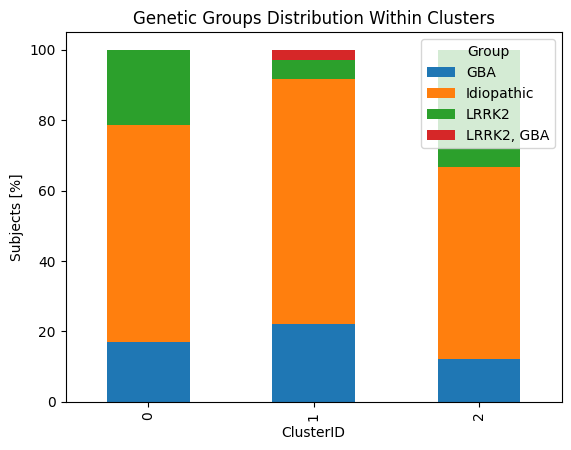

In [99]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Group'
                                           , title = 'Genetic Groups Distribution Within Clusters')

In [100]:
cl_data.groupby(['clusterID', 'Patient Type'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Patient Type
0          Intermediate    0.063830
           PIGD            0.404255
           TD              0.361702
1          Intermediate    0.166667
           PIGD            0.333333
           TD              0.333333
2          Intermediate    0.121212
           PIGD            0.212121
           TD              0.424242
Name: Subject, dtype: float64

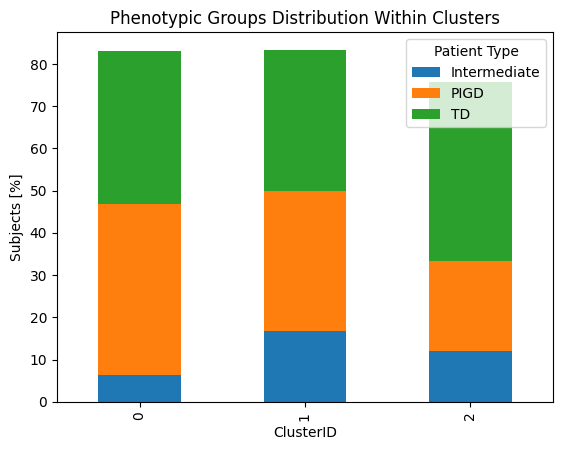

In [101]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Patient Type'
                                           , title = 'Phenotypic Groups Distribution Within Clusters')

In [102]:
cl_data.groupby(['clusterID', 'Affected side'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Affected side
0          Left             0.510638
           Right            0.425532
1          Equal            0.027778
           Left             0.416667
           Right            0.388889
2          Equal            0.030303
           Left             0.454545
           Right            0.484848
Name: Subject, dtype: float64

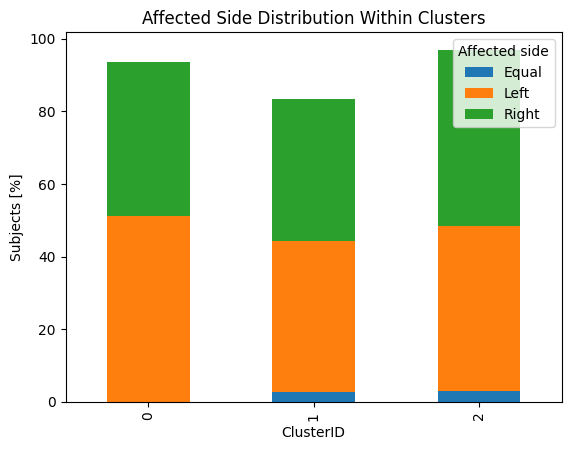

In [103]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Affected side'
                                           , title = 'Affected Side Distribution Within Clusters')

In [104]:
cl_data.groupby(['clusterID', 'Gender'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Gender
0          Female    0.340426
           Male      0.659574
1          Female    0.388889
           Male      0.611111
2          Female    0.424242
           Male      0.575758
Name: Subject, dtype: float64

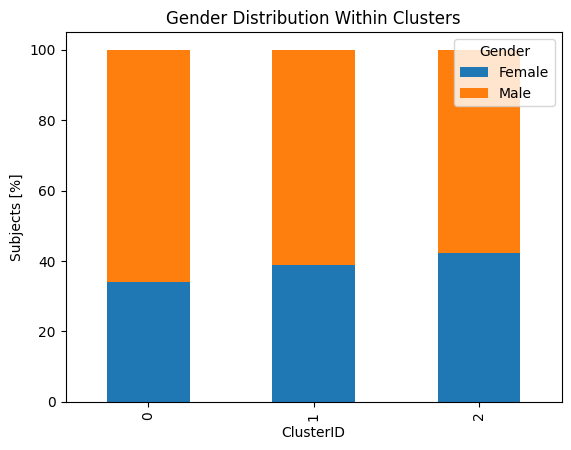

In [105]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Gender'
                                           , title = 'Gender Distribution Within Clusters')

#### Numerical Distributions

In [106]:
def plot_hist(data, feature_name, bins):
    
    for c in range(3):
        c_data = data.loc[data['clusterID'] == c]
        mean = round(c_data[feature_name].mean(), 2)
        std = round(c_data[feature_name].std(), 2)
        print(f"C{c}: Mean {feature_name} = {mean} [{std}]")
        sns.histplot(c_data, x=feature_name, stat='probability', label=c, alpha=.4, bins=bins)

    plt.legend()
    plt.title(f"{feature_name} Distribution between Clusters")
    plt.show()

In [107]:
def anova(data, feature_name):
    c0 = data.loc[data['clusterID'] == 0, feature_name].dropna()
    c1 = data.loc[data['clusterID'] == 1, feature_name].dropna()
    c2 = data.loc[data['clusterID'] == 2, feature_name].dropna()

    F, p = f_oneway(c0, c1, c2)
    print(f"F = {F:.3f}, p = {p:.4f}")

C0: Mean Age = 66.23 [9.17]
C1: Mean Age = 68.44 [8.33]
C2: Mean Age = 63.45 [10.34]


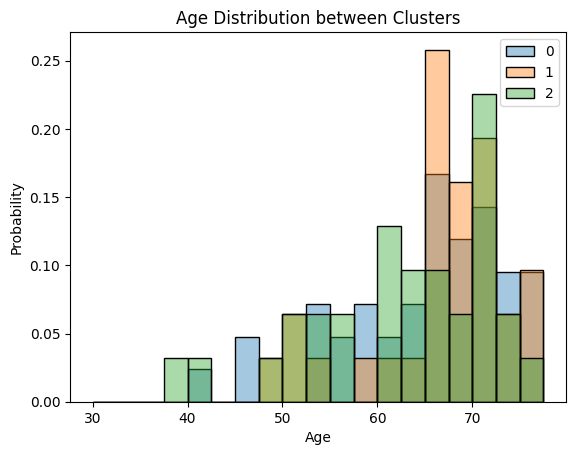

In [108]:
plot_hist(cl_data, feature_name='Age', bins=np.arange(30, 80, 2.5))

C0: Mean Age of Onset = 60.85 [9.01]
C1: Mean Age of Onset = 63.49 [7.85]
C2: Mean Age of Onset = 59.36 [10.64]


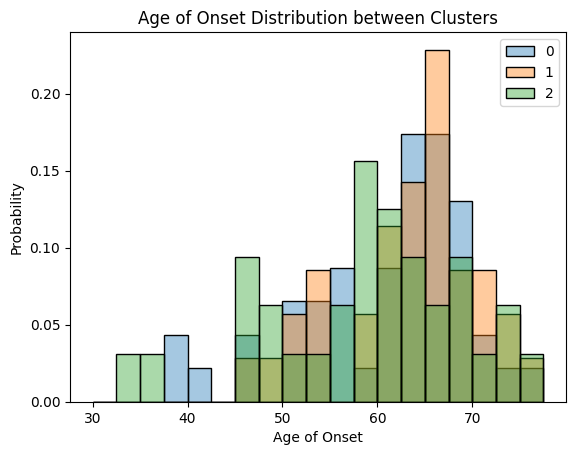

In [109]:
plot_hist(cl_data, feature_name='Age of Onset', bins=np.arange(30, 80, 2.5))

C0: Mean Disease duration = 64.62 [46.82]
C1: Mean Disease duration = 59.5 [51.76]
C2: Mean Disease duration = 49.18 [41.89]


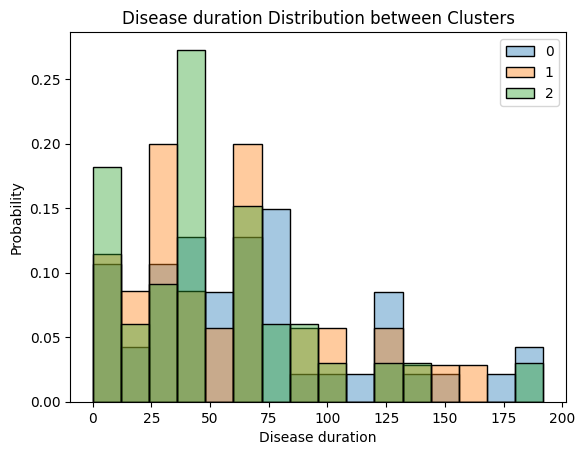

In [110]:
plot_hist(cl_data, feature_name='Disease duration', bins=np.arange(0, 200, 12))

C0: Mean UPDRS part III = 26.52 [12.97]
C1: Mean UPDRS part III = 26.42 [12.76]
C2: Mean UPDRS part III = 20.58 [10.78]


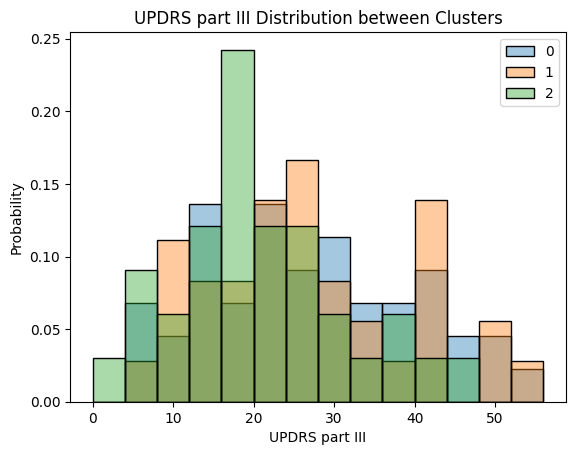

In [111]:
plot_hist(cl_data, feature_name='UPDRS part III', bins=np.arange(0, 60, 4))

C0: Mean UPDRS Total = 45.02 [22.0]
C1: Mean UPDRS Total = 40.03 [20.81]
C2: Mean UPDRS Total = 34.15 [16.84]


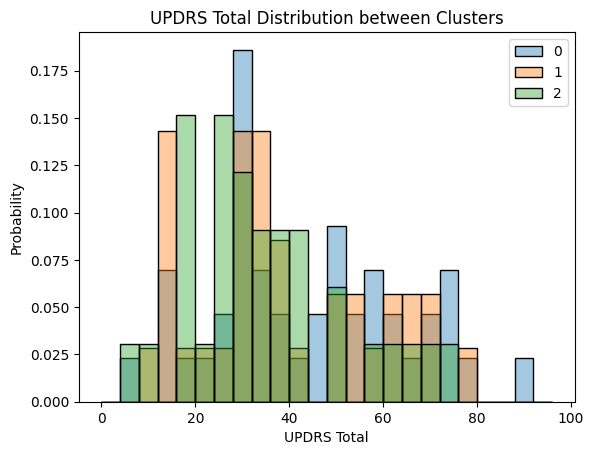

In [112]:
plot_hist(cl_data, feature_name='UPDRS Total', bins=np.arange(0, 100, 4))

C0: Mean MoCA = 24.83 [2.97]
C1: Mean MoCA = 24.42 [3.52]
C2: Mean MoCA = 26.52 [2.47]


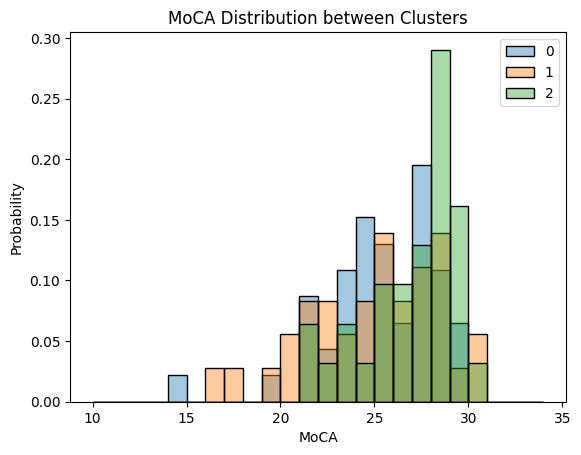

In [113]:
plot_hist(cl_data, feature_name='MoCA', bins=np.arange(10, 35, 1))

C0: Mean CTT1 = 69.02 [35.08]
C1: Mean CTT1 = 77.76 [43.0]
C2: Mean CTT1 = 49.76 [22.9]


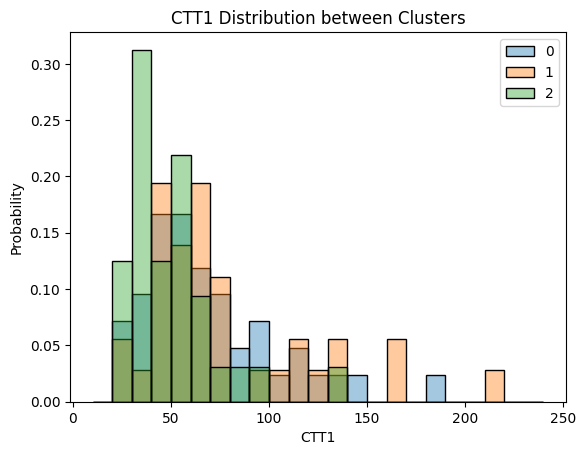

In [114]:
plot_hist(cl_data, feature_name='CTT1', bins=np.arange(10, 250, 10))

C0: Mean CTT2 = 115.01 [44.25]
C1: Mean CTT2 = 143.37 [66.96]
C2: Mean CTT2 = 90.05 [35.23]


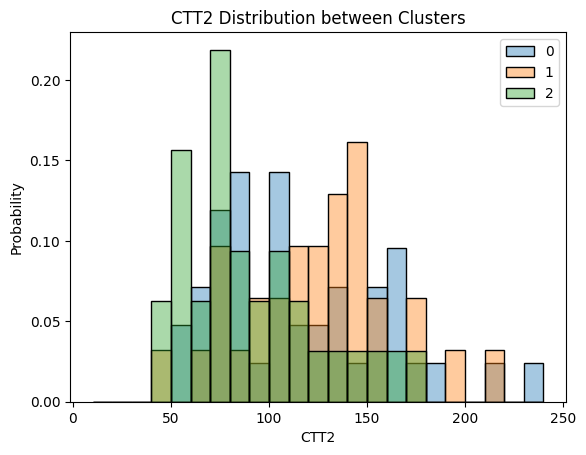

In [115]:
plot_hist(cl_data, feature_name='CTT2', bins=np.arange(10, 250, 10))

C0: Mean Gait speed usual = 1.05 [0.21]
C1: Mean Gait speed usual = 1.06 [0.19]
C2: Mean Gait speed usual = 1.05 [0.18]


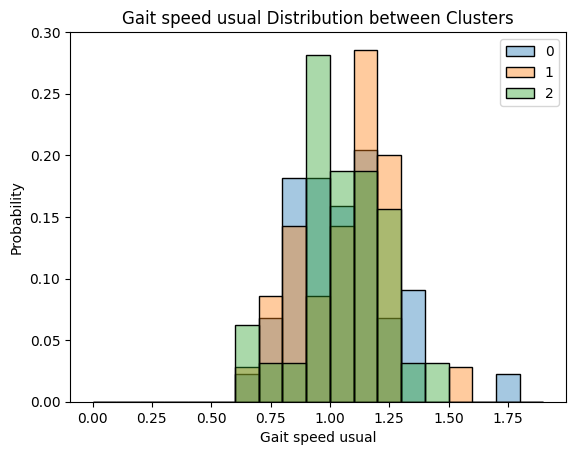

In [116]:
plot_hist(cl_data, feature_name='Gait speed usual', bins=np.arange(0, 2, 0.1))

C0: Mean Gait speed DT = 0.87 [0.23]
C1: Mean Gait speed DT = 0.91 [0.23]
C2: Mean Gait speed DT = 0.88 [0.19]


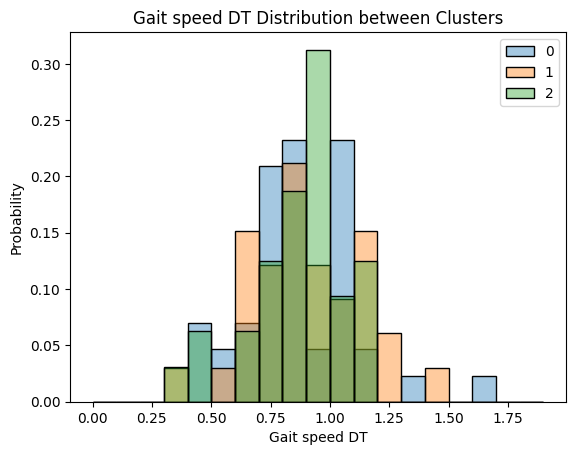

In [117]:
plot_hist(cl_data, feature_name='Gait speed DT', bins=np.arange(0, 2, 0.1))

C0: Mean LEDD = 478.09 [407.35]
C1: Mean LEDD = 363.94 [359.83]
C2: Mean LEDD = 403.15 [377.17]


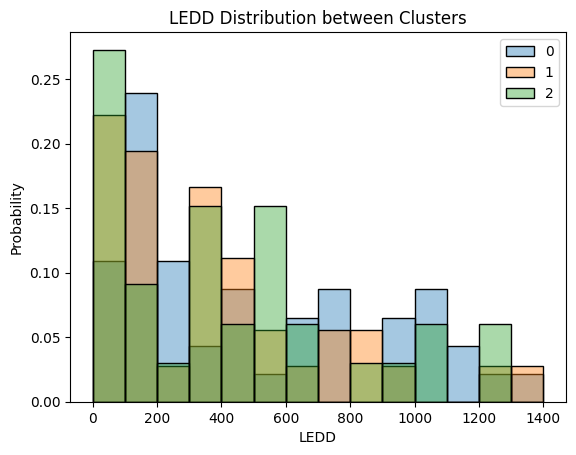

In [118]:
plot_hist(cl_data, feature_name='LEDD', bins=np.arange(0, 1500, 100))

#### Topological Distributions

In [130]:
features = feature_table.pivot_table(
    index=['Subject', 'Condition', 'Electrode'],
    columns='FeatureName',
    values='RawValue'
).reset_index()

clustered_features = pd.merge(features, clusters, on='Subject', how='left')
clustered_features.loc[clustered_features['Subject'].str.startswith('HC'), 'clusterID'] = 'HC'

In [131]:
from Topomap import TopoPlot
HEIGHT = 4
WIDTH = 3

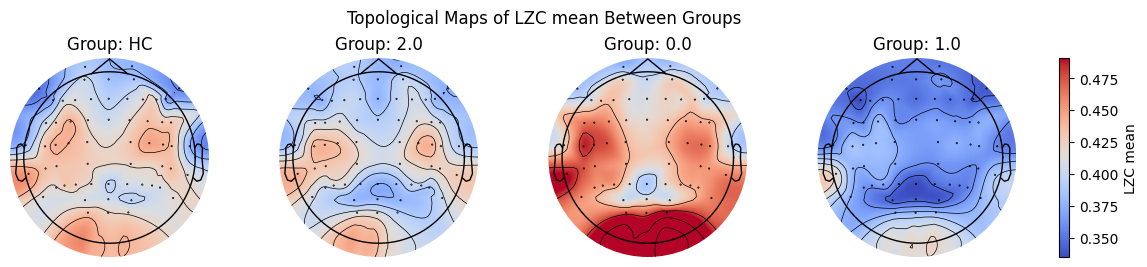

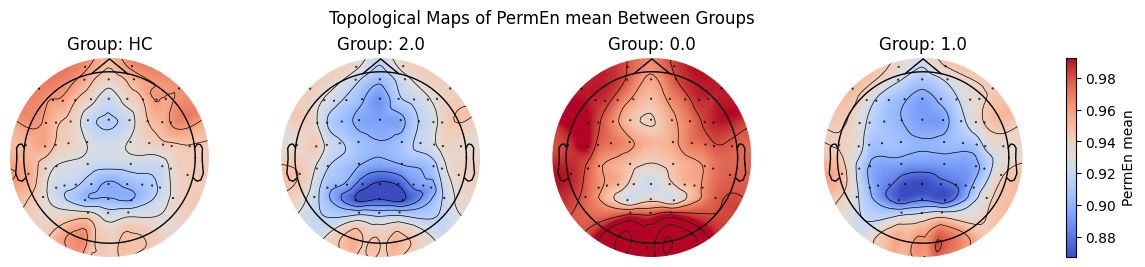

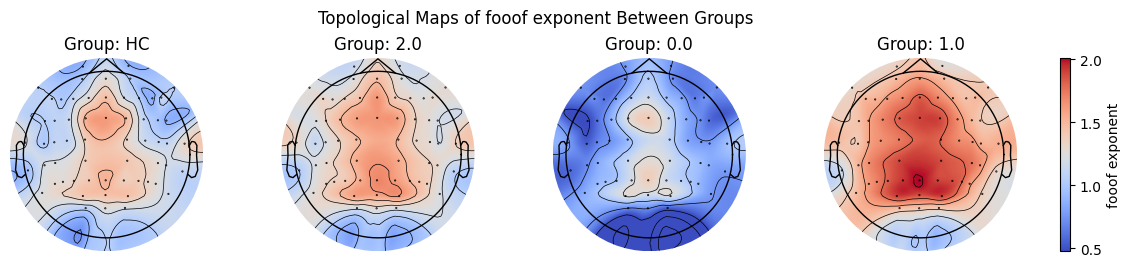

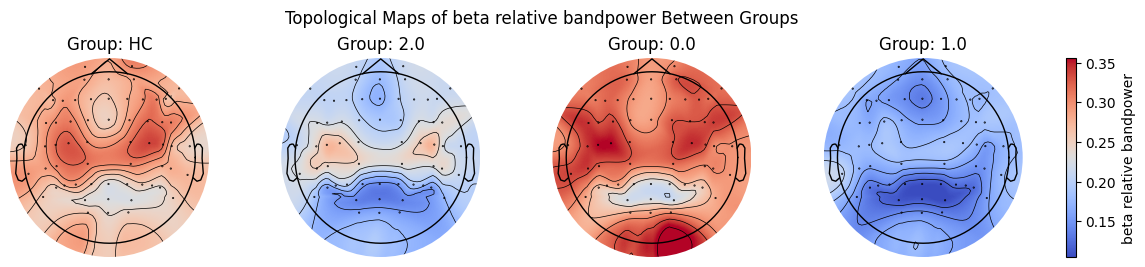

KeyboardInterrupt: 

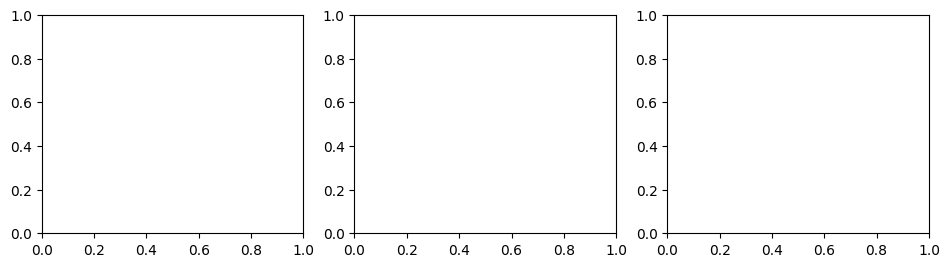

In [132]:
sit_plot = TopoPlot(
    data=clustered_features.loc[clustered_features['Condition'] == 'sit'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=MODEL_FEATURE_NAMES,
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm')

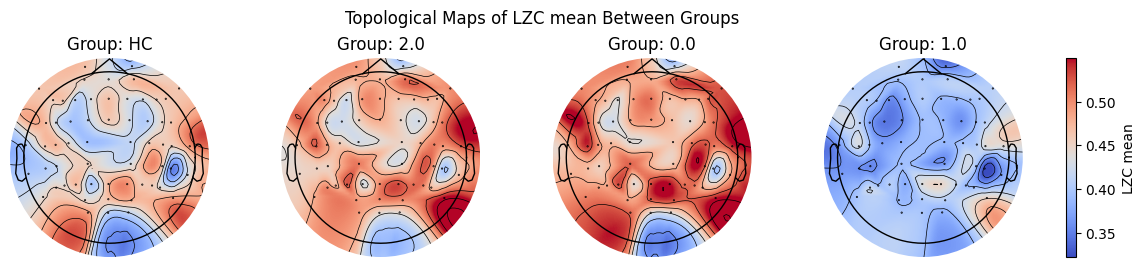

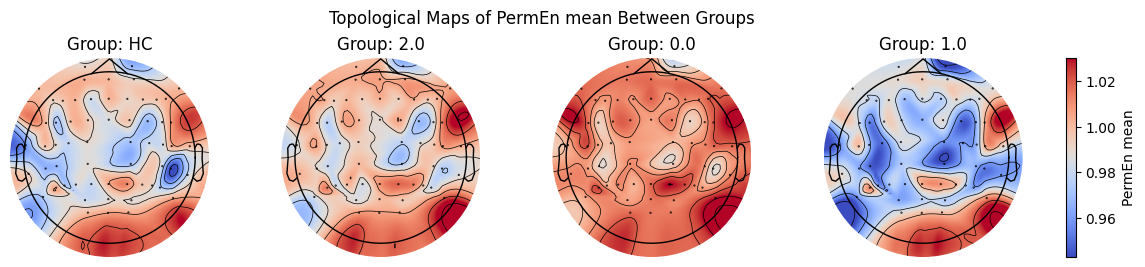

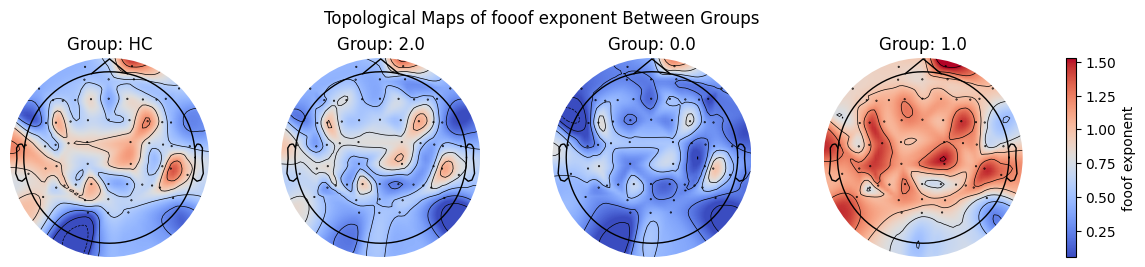

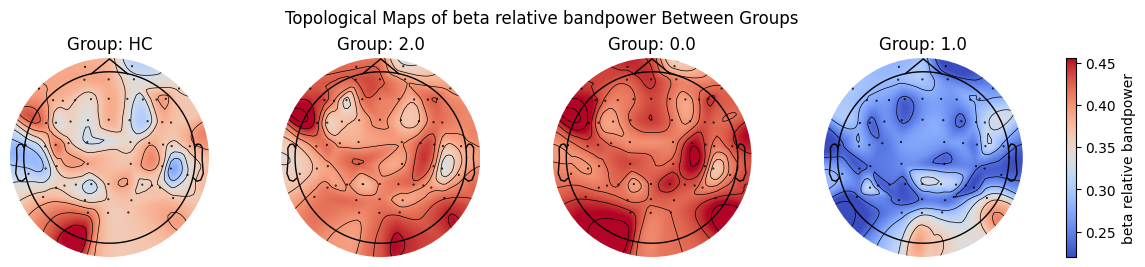

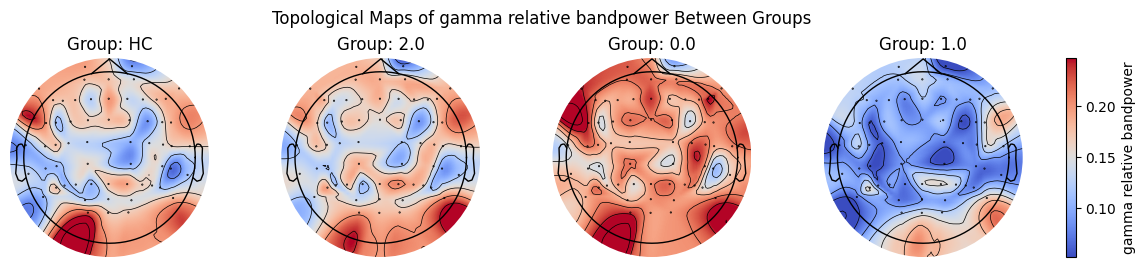

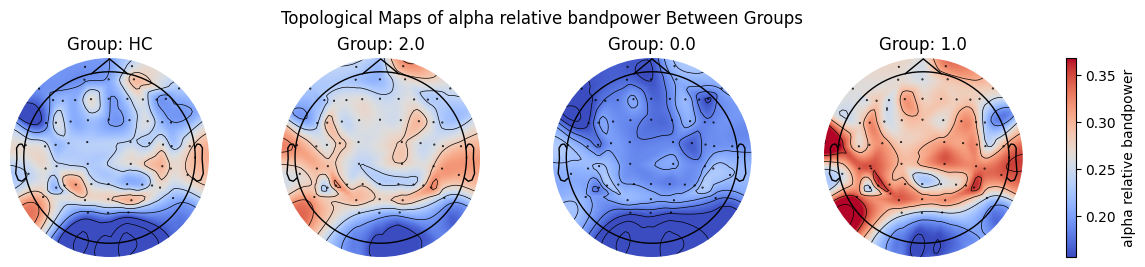

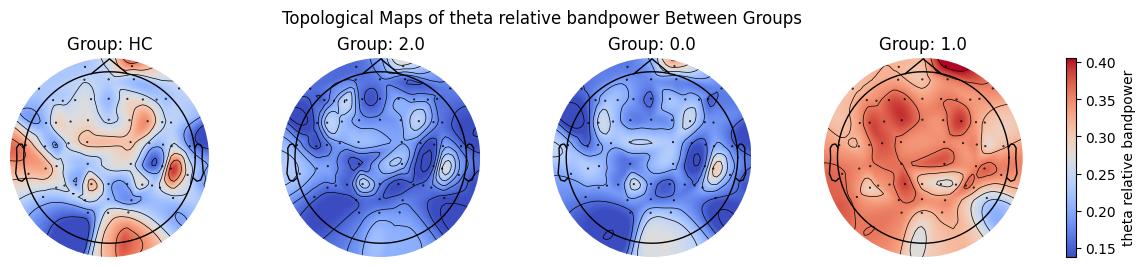

In [ ]:
walk_plot = TopoPlot(
    data=clustered_features.loc[clustered_features['Condition'] == 'walk'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=MODEL_FEATURE_NAMES,
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm')

### Further Neurophysiological Assessment

In [124]:
pd_colors = sns.color_palette("viridis", 3)   # 3 shades of orange
hc_color = "gray"

palette = {
    0: pd_colors[0],
    1: pd_colors[1],
    2: pd_colors[2],
    "HC": hc_color
}

In [125]:
relatives = ['theta_relative_bandpower', 'alpha_relative_bandpower', 'beta_relative_bandpower', 'gamma_relative_bandpower']

melted = clustered_features.melt(
    id_vars=['Condition', 'clusterID', 'Subject', 'Electrode'],
    value_vars=relatives,
    var_name='FeatureName',
    value_name='RawValue'
)


In [126]:
agg_powers = melted.groupby(['Condition', 'clusterID', 'Subject', 'FeatureName'])[['RawValue']].mean().reset_index()
agg_powers["FeatureName"] = pd.Categorical(agg_powers["FeatureName"], categories=relatives, ordered=True)
agg_powers["clusterID"] = pd.Categorical(agg_powers["clusterID"], categories=['HC', 0, 1, 2], ordered=True)

In [127]:
for band in relatives:
    print(f"Band: {band.split('_')[0]}")
    band_data = agg_powers.loc[(agg_powers['clusterID'] != 'HC') & (agg_powers['Condition'] == 'sit') & (agg_powers['FeatureName'] == band)].reset_index()
    anova(band_data, 'RawValue')
    print()

Band: theta
F = 28.361, p = 0.0000

Band: alpha
F = 29.716, p = 0.0000

Band: beta
F = 39.121, p = 0.0000

Band: gamma
F = 42.225, p = 0.0000



<Axes: xlabel='FeatureName', ylabel='clusterID'>

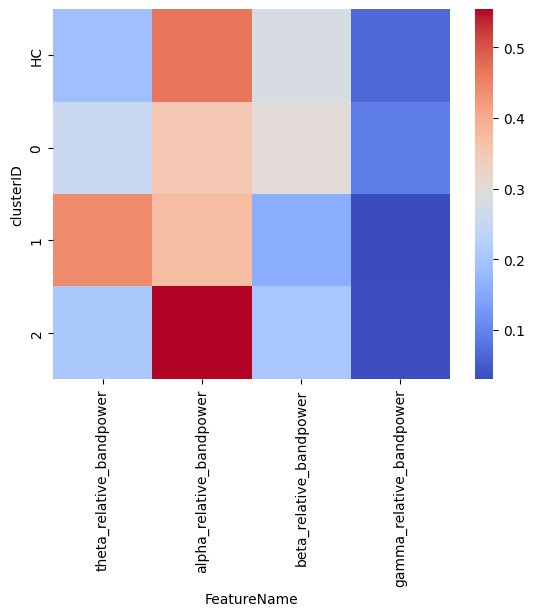

In [128]:
sns.heatmap(    agg_powers.loc[(agg_powers['Condition'] == 'sit')].pivot_table(
        index='clusterID', values='RawValue', columns='FeatureName'
    ), cmap='coolwarm')

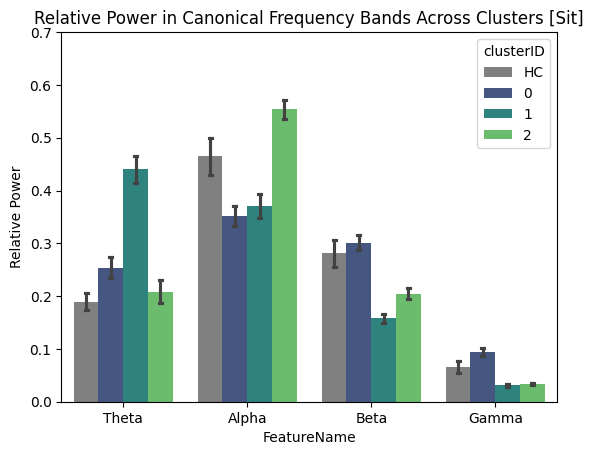

In [129]:
ax = sns.barplot(
    agg_powers.loc[(agg_powers['Condition'] == 'sit')],
    x='FeatureName', y='RawValue', hue='clusterID', palette=palette, capsize=.1, errorbar='se'
)

ax.set_xticklabels(["Theta", "Alpha", "Beta", "Gamma"])
plt.title('Relative Power in Canonical Frequency Bands Across Clusters [Sit]')
plt.ylabel('Relative Power')
plt.ylim(0, 0.7)
plt.show()

#### Temporal Complexity

In [133]:
complexities = clustered_features.groupby(['clusterID', 'Subject', 'Condition'])[['LZC_mean', 'PermEn_mean']].mean().reset_index()

In [134]:
anova(complexities.loc[complexities['Condition'] == 'sit'], 'LZC_mean')

F = 39.420, p = 0.0000


In [135]:
anova(complexities.loc[complexities['Condition'] == 'walk'], 'LZC_mean')

F = 35.193, p = 0.0000


In [136]:
clustered_features.groupby(['Condition', 'clusterID'])['LZC_mean'].mean()

Condition  clusterID
sit        0.0          0.437937
           1.0          0.362215
           2.0          0.404244
           HC           0.413853
walk       0.0          0.489591
           1.0          0.392539
           2.0          0.477010
           HC           0.443300
Name: LZC_mean, dtype: float64

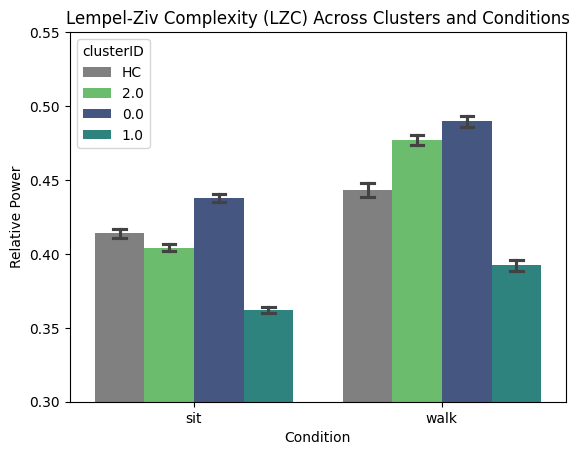

In [137]:
ax = sns.barplot(
    clustered_features,
    x='Condition', y='LZC_mean', hue='clusterID', capsize=.2, palette=palette
)


plt.ylim(.3, .55)
plt.title('Lempel-Ziv Complexity (LZC) Across Clusters and Conditions')
plt.ylabel('Relative Power')
plt.show()